In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchvision.models as vmodels
import torchaudio.models as models
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import glob
import librosa
import librosa.display
import soundfile as sf
from scipy.interpolate import interp1d
import IPython.display as ipd
import ast
import time
import sys
from nnutils import reshape_mel_spec, RainforestNetV2, Params, MelSpecDatasetV2
from scipy import stats


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load meta.csv to save metadata for training session
try:
    meta = pd.read_csv('models/meta.csv')
except:
    meta = pd.DataFrame()


In [4]:
# Hyper parameters      
params = Params()

In [5]:
# set here if the model should be trained on the full dataset
train_full = False

In [6]:
validate = True and not train_full
train_split = 0.8

In [7]:
# CUDA
is_cuda = True and torch.cuda.is_available()
cpu = torch.device('cpu')
gpu = torch.device('cuda')
device = gpu if is_cuda else cpu

print ('cuda: ', is_cuda)

torch.cuda.empty_cache()

cuda:  True


In [8]:
train_test_split = None if train_full else (train_split, True)
trainset = MelSpecDatasetV2(params, train_test_split=train_test_split)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=params.TRAIN_BATCH_SIZE,shuffle=True)

tensor([0.0652, 0.0631, 0.0573, 0.0728, 0.0961, 0.0620, 0.0983, 0.0905, 0.0728,
        0.0619, 0.0851, 0.0839, 0.0725, 0.0857, 1.0000, 0.0910, 0.0506, 0.0770,
        0.0756, 0.0812, 0.0922, 0.0724, 0.0562, 0.0823])
torch.Size([3, 224, 1153])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


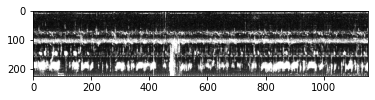

In [9]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

ms, l = trainset[0]
print (l)
print (ms.shape)
imshow(ms)

In [10]:
model = RainforestNetV2().to(device)
model.train()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=params.LR)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Vasishta/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth


In [11]:
start_time = time.time()
losses = []
losses_detail = []

for epoch in range(params.EPOCHS):
    running_loss = 0.0
    t = tqdm(trainloader, desc="epoch {}/{}, running loss: {}".format(epoch+1, params.EPOCHS, 0.0))
    for i, data in enumerate(t):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        del inputs
        del labels

        torch.cuda.empty_cache()

        running_loss += loss.item()
        losses_detail.append(loss.item())
        loss_interval = 10
        if i % loss_interval == loss_interval-1:    # print every 50 mini-batches
            #print('[%d %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 50))
            interval_loss = running_loss/loss_interval
            losses.append(interval_loss)
            t.set_description("epoch {}/{}, running_loss: {:.2f}".format(epoch+1, params.EPOCHS, interval_loss))
            t.refresh()

            running_loss = 0.0

end_time = time.time()
print ('\n-------- DONE --------')
print ('start time: {}'.format(start_time))
print ('end time: {}\n'.format(end_time))

duration = end_time-start_time
print ('training duration: {}'.format(duration))

model_path = 'models/rainforest{}.pt'.format(end_time)
torch.save(model.state_dict(), model_path)



-------- DONE --------
start time: 1608874633.949333
end time: 1608875529.2274983

training duration: 895.2781653404236


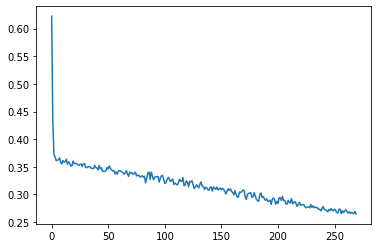

In [12]:
fig, ax = plt.subplots()
ax.plot(losses)
plt.show()

In [13]:
# validate

if validate:
    validset = MelSpecDatasetV2(params, train_test_split=(train_split, False))
    validloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=False)
else:
    mdata = params.__to_dict__()
    mdata.update({
        'start_time': start_time,
        'end_time': end_time,
        'train_duration': duration,
        'model_path': model_path,
    })
    meta = meta.append(mdata, ignore_index=True)
    meta.to_csv("models/meta.csv", index=False, float_format='%.5f')

In [14]:
if validate:    
    valid_model = RainforestNetV2()
    valid_model.load_state_dict(torch.load(model_path))
    valid_model.eval()
    valid_model = valid_model.to(device)
    
    valid_results = pd.DataFrame()
    with torch.no_grad():
        for i, data in enumerate(tqdm(validloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = valid_model(inputs)
            res = outputs[0].to(cpu).numpy()

            valid_results = valid_results.append({ 'result': res }, ignore_index=True)
    
    submission = pd.DataFrame()
    
    valid_ids = validset.get_recording_ids()

    for idx in range(len(valid_results)):
        ex = valid_results.iloc[idx]
        recording_id = valid_ids[idx]
        result = ex.result

        species = 0
        o = {}
        for r in result:
            s = 's{}'.format(species)
            o[s] = r
            species += 1 
        o["recording_id"] = recording_id
        submission = submission.append(o, ignore_index=True)
    
    del valid_results
    cols = ['recording_id', 's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23']
    submission = submission[cols]

In [15]:
if validate:
    from utils import score
    s = score(submission)
    print(s)
    mdata = params.__to_dict__()
    mdata.update({
        'start_time': start_time,
        'end_time': end_time,
        'train_duration': duration,
        'model_path': model_path,
        'validation_score': s
    })
    meta = meta.append(mdata, ignore_index=True)
    meta.to_csv("models/meta.csv", index=False, float_format='%.5f')

(0.4434143210436392, 0.44513283895039407)
